# Method 5 - Best Ideas High Minus Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
low_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

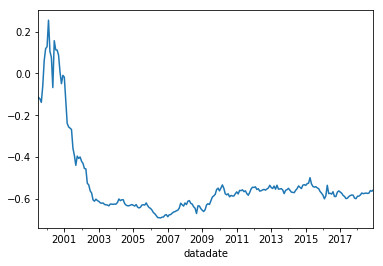

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.118352
2000-12-31   -0.114514
2001-12-31   -0.394156
2002-12-31   -0.346967
2003-12-31   -0.042413
2004-12-31   -0.006658
2005-12-31   -0.038762
2006-12-31   -0.094461
2007-12-31    0.126458
2008-12-31   -0.033350
2009-12-31    0.277518
2010-12-31   -0.059675
2011-12-31    0.074031
2012-12-31    0.019923
2013-12-31   -0.044940
2014-12-31    0.053673
2015-12-31   -0.086740
2016-12-31    0.025418
2017-12-31   -0.084931
2018-12-31    0.103825
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     15.12
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.57e-11
Time:                        04:48:57   Log-Likelihood:                 443.12
No. Observations:                 234   AIC:                            -876.2
Df Residuals:                     229   BIC:                            -859.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.942      0.347      -0.007       0.003
mktrf          0.1124      0.069      1.637      0.103      -0.023       0.248
me             0.2254      0.080      2.823      0.005       0.068       0.383
ia            -0.3612      0.121     -2.976      0.003      -0.600      -0.122
roe           -0.2446      0.104     -2.354      0.019      -0.449      -0.040
==============================================================================
Omnibus:                       53.319   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.094
Skew:                           0.739   Prob(JB):                     1.02e-63
Kurtosis:                       8.251   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     10.49
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.01e-08
Time:                        04:48:57   Log-Likelihood:                 443.12
No. Observations:                 234   AIC:                            -876.2
Df Residuals:                     229   BIC:                            -859.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.846      0.398      -0.008       0.003
mktrf          0.1124      0.099      1.131      0.258      -0.082       0.307
me             0.2254      0.163      1.381      0.167      -0.095       0.545
ia            -0.3612      0.152     -2.380      0.017      -0.659      -0.064
roe           -0.2446      0.109     -2.244      0.025      -0.458      -0.031
==============================================================================
Omnibus:                       53.319   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.094
Skew:                           0.739   Prob(JB):                     1.02e-63
Kurtosis:                       8.251   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     15.27
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.36e-11
Time:                        04:48:57   Log-Likelihood:                 443.12
No. Observations:                 234   AIC:                            -876.2
Df Residuals:                     229   BIC:                            -859.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.731      0.465      -0.009       0.004
mktrf          0.1124      0.094      1.199      0.231      -0.071       0.296
me             0.2254      0.161      1.396      0.163      -0.091       0.542
ia            -0.3612      0.161     -2.240      0.025      -0.677      -0.045
roe           -0.2446      0.114     -2.154      0.031      -0.467      -0.022
==============================================================================
Omnibus:                       53.319   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.094
Skew:                           0.739   Prob(JB):                     1.02e-63
Kurtosis:                       8.251   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     16.24
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.07e-13
Time:                        04:48:57   Log-Likelihood:                 451.35
No. Observations:                 234   AIC:                            -890.7
Df Residuals:                     228   BIC:                            -870.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.648      0.518      -0.006       0.003
mktrf          0.1162      0.067      1.745      0.082      -0.015       0.247
smb            0.1380      0.088      1.572      0.117      -0.035       0.311
hml           -0.1914      0.104     -1.848      0.066      -0.395       0.013
rmw           -0.4300      0.117     -3.672      0.000      -0.661      -0.199
cma            0.0336      0.149      0.226      0.822      -0.260       0.327
==============================================================================
Omnibus:                       46.005   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.786
Skew:                           0.656   Prob(JB):                     2.29e-47
Kurtosis:                       7.506   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     10.28
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.72e-09
Time:                        04:48:57   Log-Likelihood:                 451.35
No. Observations:                 234   AIC:                            -890.7
Df Residuals:                     228   BIC:                            -870.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.003     -0.635      0.525      -0.007       0.003
mktrf          0.1162      0.075      1.544      0.123      -0.031       0.264
smb            0.1380      0.135      1.024      0.306      -0.126       0.402
hml           -0.1914      0.148     -1.291      0.197      -0.482       0.099
rmw           -0.4300      0.106     -4.050      0.000      -0.638      -0.222
cma            0.0336      0.146      0.229      0.819      -0.253       0.321
==============================================================================
Omnibus:                       46.005   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.786
Skew:                           0.656   Prob(JB):                     2.29e-47
Kurtosis:                       7.506   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     11.68
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.64e-10
Time:                        04:48:57   Log-Likelihood:                 451.35
No. Observations:                 234   AIC:                            -890.7
Df Residuals:                     228   BIC:                            -870.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.003     -0.557      0.578      -0.007       0.004
mktrf          0.1162      0.075      1.544      0.123      -0.031       0.264
smb            0.1380      0.125      1.108      0.268      -0.106       0.382
hml           -0.1914      0.156     -1.224      0.221      -0.498       0.115
rmw           -0.4300      0.120     -3.593      0.000      -0.665      -0.195
cma            0.0336      0.147      0.229      0.819      -0.254       0.321
==============================================================================
Omnibus:                       46.005   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.786
Skew:                           0.656   Prob(JB):                     2.29e-47
Kurtosis:                       7.506   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     17.43
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.69e-12
Time:                        04:48:57   Log-Likelihood:                 446.80
No. Observations:                 234   AIC:                            -883.6
Df Residuals:                     229   BIC:                            -866.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.002     -1.660      0.098      -0.009       0.001
mktrf          0.2259      0.062      3.630      0.000       0.103       0.349
smb            0.3154      0.078      4.059      0.000       0.162       0.468
hml           -0.2563      0.077     -3.321      0.001      -0.408      -0.104
umd            0.0112      0.051      0.221      0.825      -0.089       0.111
==============================================================================
Omnibus:                       40.960   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.325
Skew:                           0.635   Prob(JB):                     1.87e-34
Kurtosis:                       6.784   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     6.199
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.41e-05
Time:                        04:48:57   Log-Likelihood:                 446.80
No. Observations:                 234   AIC:                            -883.6
Df Residuals:                     229   BIC:                            -866.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.003     -1.528      0.127      -0.009       0.001
mktrf          0.2259      0.087      2.595      0.009       0.055       0.396
smb            0.3154      0.125      2.520      0.012       0.070       0.561
hml           -0.2563      0.107     -2.389      0.017      -0.467      -0.046
umd            0.0112      0.077      0.145      0.885      -0.140       0.163
==============================================================================
Omnibus:                       40.960   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.325
Skew:                           0.635   Prob(JB):                     1.87e-34
Kurtosis:                       6.784   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     6.258
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.53e-05
Time:                        04:48:57   Log-Likelihood:                 446.80
No. Observations:                 234   AIC:                            -883.6
Df Residuals:                     229   BIC:                            -866.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.003     -1.319      0.187      -0.010       0.002
mktrf          0.2259      0.089      2.530      0.011       0.051       0.401
smb            0.3154      0.106      2.983      0.003       0.108       0.523
hml           -0.2563      0.116     -2.201      0.028      -0.485      -0.028
umd            0.0112      0.079      0.141      0.888      -0.144       0.166
==============================================================================
Omnibus:                       40.960   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.325
Skew:                           0.635   Prob(JB):                     1.87e-34
Kurtosis:                       6.784   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     11.92
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.88e-08
Time:                        04:48:57   Log-Likelihood:                 210.16
No. Observations:                 120   AIC:                            -410.3
Df Residuals:                     115   BIC:                            -396.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068      0.004     -1.650      0.102      -0.015       0.001
mktrf          0.1127      0.111      1.019      0.310      -0.106       0.332
me             0.3711      0.109      3.398      0.001       0.155       0.587
ia            -0.6111      0.171     -3.574      0.001      -0.950      -0.272
roe           -0.0889      0.151     -0.587      0.558      -0.389       0.211
==============================================================================
Omnibus:                       31.949   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.828
Skew:                           0.899   Prob(JB):                     7.73e-23
Kurtosis:                       7.139   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     12.22
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.58e-08
Time:                        04:48:57   Log-Likelihood:                 210.16
No. Observations:                 120   AIC:                            -410.3
Df Residuals:                     115   BIC:                            -396.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068      0.004     -1.536      0.125      -0.015       0.002
mktrf          0.1127      0.180      0.626      0.531      -0.240       0.466
me             0.3711      0.179      2.075      0.038       0.021       0.722
ia            -0.6111      0.160     -3.815      0.000      -0.925      -0.297
roe           -0.0889      0.160     -0.555      0.579      -0.403       0.225
==============================================================================
Omnibus:                       31.949   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.828
Skew:                           0.899   Prob(JB):                     7.73e-23
Kurtosis:                       7.139   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     23.18
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.56e-14
Time:                        04:48:57   Log-Likelihood:                 210.16
No. Observations:                 120   AIC:                            -410.3
Df Residuals:                     115   BIC:                            -396.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068      0.005     -1.309      0.191      -0.017       0.003
mktrf          0.1127      0.186      0.607      0.544      -0.251       0.476
me             0.3711      0.177      2.092      0.036       0.023       0.719
ia            -0.6111      0.135     -4.524      0.000      -0.876      -0.346
roe           -0.0889      0.172     -0.517      0.605      -0.426       0.248
==============================================================================
Omnibus:                       31.949   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.828
Skew:                           0.899   Prob(JB):                     7.73e-23
Kurtosis:                       7.139   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     13.68
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.87e-10
Time:                        04:48:57   Log-Likelihood:                 217.54
No. Observations:                 120   AIC:                            -423.1
Df Residuals:                     114   BIC:                            -406.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.004     -1.314      0.192      -0.013       0.003
mktrf          0.1396      0.110      1.268      0.208      -0.079       0.358
smb            0.3003      0.125      2.408      0.018       0.053       0.547
hml           -0.4351      0.153     -2.847      0.005      -0.738      -0.132
rmw           -0.1793      0.180     -0.995      0.322      -0.536       0.178
cma           -0.0225      0.197     -0.114      0.910      -0.414       0.369
==============================================================================
Omnibus:                       22.177   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.538
Skew:                           0.657   Prob(JB):                     5.28e-13
Kurtosis:                       6.096   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     16.68
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.45e-12
Time:                        04:48:57   Log-Likelihood:                 217.54
No. Observations:                 120   AIC:                            -423.1
Df Residuals:                     114   BIC:                            -406.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.004     -1.202      0.229      -0.014       0.003
mktrf          0.1396      0.136      1.027      0.304      -0.127       0.406
smb            0.3003      0.171      1.756      0.079      -0.035       0.636
hml           -0.4351      0.156     -2.785      0.005      -0.741      -0.129
rmw           -0.1793      0.156     -1.151      0.250      -0.485       0.126
cma           -0.0225      0.190     -0.118      0.906      -0.395       0.350
==============================================================================
Omnibus:                       22.177   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.538
Skew:                           0.657   Prob(JB):                     5.28e-13
Kurtosis:                       6.096   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     30.94
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.91e-20
Time:                        04:48:57   Log-Likelihood:                 217.54
No. Observations:                 120   AIC:                            -423.1
Df Residuals:                     114   BIC:                            -406.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.005     -1.007      0.314      -0.015       0.005
mktrf          0.1396      0.135      1.035      0.301      -0.125       0.404
smb            0.3003      0.151      1.987      0.047       0.004       0.597
hml           -0.4351      0.164     -2.657      0.008      -0.756      -0.114
rmw           -0.1793      0.164     -1.093      0.274      -0.501       0.142
cma           -0.0225      0.196     -0.115      0.909      -0.407       0.362
==============================================================================
Omnibus:                       22.177   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.538
Skew:                           0.657   Prob(JB):                     5.28e-13
Kurtosis:                       6.096   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     17.79
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.14e-11
Time:                        04:48:57   Log-Likelihood:                 218.25
No. Observations:                 120   AIC:                            -426.5
Df Residuals:                     115   BIC:                            -412.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0066      0.004     -1.761      0.081      -0.014       0.001
mktrf          0.2389      0.091      2.624      0.010       0.059       0.419
smb            0.3503      0.104      3.379      0.001       0.145       0.556
hml           -0.4241      0.104     -4.085      0.000      -0.630      -0.218
umd            0.0511      0.064      0.798      0.427      -0.076       0.178
==============================================================================
Omnibus:                       19.235   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.627
Skew:                           0.608   Prob(JB):                     5.54e-10
Kurtosis:                       5.654   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     16.92
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.17e-11
Time:                        04:48:57   Log-Likelihood:                 218.25
No. Observations:                 120   AIC:                            -426.5
Df Residuals:                     115   BIC:                            -412.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0066      0.004     -1.637      0.102      -0.015       0.001
mktrf          0.2389      0.123      1.937      0.053      -0.003       0.481
smb            0.3503      0.121      2.887      0.004       0.112       0.588
hml           -0.4241      0.098     -4.337      0.000      -0.616      -0.232
umd            0.0511      0.086      0.594      0.553      -0.118       0.220
==============================================================================
Omnibus:                       19.235   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.627
Skew:                           0.608   Prob(JB):                     5.54e-10
Kurtosis:                       5.654   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     27.82
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.66e-16
Time:                        04:48:57   Log-Likelihood:                 218.25
No. Observations:                 120   AIC:                            -426.5
Df Residuals:                     115   BIC:                            -412.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0066      0.005     -1.396      0.163      -0.016       0.003
mktrf          0.2389      0.123      1.940      0.052      -0.002       0.480
smb            0.3503      0.092      3.789      0.000       0.169       0.531
hml           -0.4241      0.070     -6.092      0.000      -0.561      -0.288
umd            0.0511      0.092      0.557      0.578      -0.129       0.231
==============================================================================
Omnibus:                       19.235   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.627
Skew:                           0.608   Prob(JB):                     5.54e-10
Kurtosis:                       5.654   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     5.999
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000211
Time:                        04:48:57   Log-Likelihood:                 257.80
No. Observations:                 114   AIC:                            -505.6
Df Residuals:                     109   BIC:                            -491.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.452      0.652      -0.004       0.006
mktrf          0.1619      0.076      2.136      0.035       0.012       0.312
me            -0.1562      0.117     -1.334      0.185      -0.388       0.076
ia             0.2463      0.162      1.517      0.132      -0.075       0.568
roe           -0.4702      0.143     -3.296      0.001      -0.753      -0.187
==============================================================================
Omnibus:                        5.400   Durbin-Watson:                   2.256
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                6.096
Skew:                          -0.271   Prob(JB):                       0.0475
Kurtosis:                       3.995   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     5.729
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000319
Time:                        04:48:57   Log-Likelihood:                 257.80
No. Observations:                 114   AIC:                            -505.6
Df Residuals:                     109   BIC:                            -491.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.558      0.577      -0.003       0.005
mktrf          0.1619      0.096      1.684      0.092      -0.027       0.350
me            -0.1562      0.145     -1.074      0.283      -0.441       0.129
ia             0.2463      0.169      1.462      0.144      -0.084       0.577
roe           -0.4702      0.196     -2.397      0.017      -0.855      -0.086
==============================================================================
Omnibus:                        5.400   Durbin-Watson:                   2.256
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                6.096
Skew:                          -0.271   Prob(JB):                       0.0475
Kurtosis:                       3.995   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     7.647
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.81e-05
Time:                        04:48:58   Log-Likelihood:                 257.80
No. Observations:                 114   AIC:                            -505.6
Df Residuals:                     109   BIC:                            -491.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.626      0.532      -0.002       0.005
mktrf          0.1619      0.101      1.609      0.108      -0.035       0.359
me            -0.1562      0.152     -1.025      0.305      -0.455       0.142
ia             0.2463      0.184      1.337      0.181      -0.115       0.607
roe           -0.4702      0.188     -2.506      0.012      -0.838      -0.102
==============================================================================
Omnibus:                        5.400   Durbin-Watson:                   2.256
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                6.096
Skew:                          -0.271   Prob(JB):                       0.0475
Kurtosis:                       3.995   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     5.136
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000289
Time:                        04:48:58   Log-Likelihood:                 258.62
No. Observations:                 114   AIC:                            -505.2
Df Residuals:                     108   BIC:                            -488.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.003      0.226      0.822      -0.005       0.006
mktrf          0.1570      0.072      2.177      0.032       0.014       0.300
smb           -0.1240      0.117     -1.059      0.292      -0.356       0.108
hml            0.3430      0.149      2.297      0.024       0.047       0.639
rmw           -0.2441      0.183     -1.335      0.185      -0.607       0.118
cma            0.1001      0.232      0.431      0.667      -0.360       0.560
==============================================================================
Omnibus:                        9.987   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               23.869
Skew:                           0.095   Prob(JB):                     6.56e-06
Kurtosis:                       5.234   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     4.709
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000627
Time:                        04:48:58   Log-Likelihood:                 258.62
No. Observations:                 114   AIC:                            -505.2
Df Residuals:                     108   BIC:                            -488.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.273      0.785      -0.004       0.005
mktrf          0.1570      0.082      1.918      0.055      -0.003       0.317
smb           -0.1240      0.103     -1.202      0.229      -0.326       0.078
hml            0.3430      0.114      3.016      0.003       0.120       0.566
rmw           -0.2441      0.238     -1.024      0.306      -0.711       0.223
cma            0.1001      0.159      0.631      0.528      -0.211       0.411
==============================================================================
Omnibus:                        9.987   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               23.869
Skew:                           0.095   Prob(JB):                     6.56e-06
Kurtosis:                       5.234   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     4.711
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000624
Time:                        04:48:58   Log-Likelihood:                 258.62
No. Observations:                 114   AIC:                            -505.2
Df Residuals:                     108   BIC:                            -488.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.295      0.768      -0.003       0.004
mktrf          0.1570      0.090      1.735      0.083      -0.020       0.334
smb           -0.1240      0.099     -1.256      0.209      -0.318       0.070
hml            0.3430      0.118      2.909      0.004       0.112       0.574
rmw           -0.2441      0.221     -1.106      0.269      -0.677       0.188
cma            0.1001      0.138      0.725      0.468      -0.170       0.371
==============================================================================
Omnibus:                        9.987   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               23.869
Skew:                           0.095   Prob(JB):                     6.56e-06
Kurtosis:                       5.234   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     6.087
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000185
Time:                        04:48:58   Log-Likelihood:                 257.95
No. Observations:                 114   AIC:                            -505.9
Df Residuals:                     109   BIC:                            -492.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.194      0.847      -0.005       0.006
mktrf          0.1628      0.072      2.269      0.025       0.021       0.305
smb           -0.0699      0.112     -0.625      0.534      -0.292       0.152
hml            0.3666      0.115      3.182      0.002       0.138       0.595
umd           -0.0667      0.087     -0.767      0.445      -0.239       0.106
==============================================================================
Omnibus:                       10.614   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               25.487
Skew:                           0.161   Prob(JB):                     2.92e-06
Kurtosis:                       5.294   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     5.324
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000591
Time:                        04:48:58   Log-Likelihood:                 257.95
No. Observations:                 114   AIC:                            -505.9
Df Residuals:                     109   BIC:                            -492.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.227      0.820      -0.004       0.005
mktrf          0.1628      0.083      1.957      0.050      -0.000       0.326
smb           -0.0699      0.111     -0.628      0.530      -0.288       0.148
hml            0.3666      0.117      3.146      0.002       0.138       0.595
umd           -0.0667      0.078     -0.856      0.392      -0.219       0.086
==============================================================================
Omnibus:                       10.614   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               25.487
Skew:                           0.161   Prob(JB):                     2.92e-06
Kurtosis:                       5.294   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     4.601
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00180
Time:                        04:48:58   Log-Likelihood:                 257.95
No. Observations:                 114   AIC:                            -505.9
Df Residuals:                     109   BIC:                            -492.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.252      0.801      -0.003       0.004
mktrf          0.1628      0.089      1.823      0.068      -0.012       0.338
smb           -0.0699      0.109     -0.640      0.522      -0.284       0.144
hml            0.3666      0.131      2.792      0.005       0.109       0.624
umd           -0.0667      0.079     -0.846      0.398      -0.221       0.088
==============================================================================
Omnibus:                       10.614   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               25.487
Skew:                           0.161   Prob(JB):                     2.92e-06
Kurtosis:                       5.294   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""